# Traveling Salesman Problem

The travelling salesman problem, asks the following question: Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?

https://en.wikipedia.org/wiki/Travelling_salesman_problem

### First we import python libraries and set up the directory of our code.

In [3]:
import numpy as np
import os, sys, copy
import matplotlib.pyplot as plt
from collections import namedtuple

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

### Here we import all our custom GA code.

In [5]:
# Import main classes.
from pygenalgo.genome.gene import Gene
from pygenalgo.genome.chromosome import Chromosome
from pygenalgo.engines.standard_ga import StandardGA

# Import Selection Operator(s).
from pygenalgo.operators.selection.linear_rank_selector import LinearRankSelector

# Import Crossover Operator(s).
from pygenalgo.operators.crossover.order_crossover import OrderCrossover

# Import Mutation Operator(s).
from pygenalgo.operators.mutation.swap_mutator import SwapMutator

### We create a small data sructure to hold the city information.

In [7]:
# Data structure to represent a city on a grid.
City = namedtuple("City", ["Name", "x", "y"])

### Then we create a list of cities on a grid with (x, y) coordinates.

In [9]:
# Define n_cities on a grid [0, 15] x [0, 15]
rome   = City("Rome"  , 3,  2)
athens = City("Athens", 7,  3)
lisbon = City("Lisbon", 14, 2)
madrid = City("Madrid", 3,  7)
berlin = City("Berlin", 12, 7)
paris  = City("Paris" , 2, 14)
london = City("London", 7, 12)
moscow = City("Moscow", 12,12)
dublin = City("Dublin", 6,  9)
cairo  = City("Cairo" , 10, 8)

# Put all the cities in a list.
city_list = [rome, athens, lisbon, madrid, berlin,
             paris, london, moscow, dublin, cairo]

### Lets plot the list.

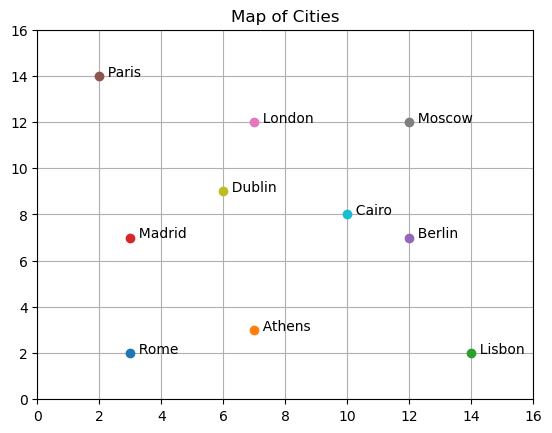

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

for city in city_list:
    ax.plot(city.x, city.y, 'o')
    ax.annotate(f'  {city.Name}', xy=(city.x, city.y))
# _end_for_

ax.grid()

ax.set_xlim([0, 16])
ax.set_ylim([0, 16])

plt.title("Map of Cities")
plt.show()

In [12]:
# Define the fitness function.
def fun_TSP(individual: Chromosome, f_min: bool = True):
    """
    This function computes the total distance travelled from all cities.
    We assume (hard constraint) that the order that they cities appear
    in the genome list, is the same order the traveler is visiting them.

    When we reach the end of the list we make one extra calculation from
    the last entry of the list to the first: [-1] -> [0].

    To discourage loops if two consecutive cities are identical we add a
    penalty to the total distance. However, this should not happen if we
    use only swap mutation operator.
    """

    # Compute the distance.
    total_distance = 0.0

    # Get the size of the genome.
    N = len(individual.genome)
    
    # Iterate through all the cities.
    for i, city_a in enumerate(individual.genome):

        # The next index ('j') should point at the
        # begining of the list, once we reach at the end.
        j = i + 1 if i < N-1 else 0

        # Get the next city in the list.
        city_b = individual.genome[j]

        # If the cities are the same, add penatly.
        if city_a == city_b:
            total_distance += 15.0
        else:

            # Otherwise compute their distance.
            x_a, y_a = city_a.datum.x, city_a.datum.y
            x_b, y_b = city_b.datum.x, city_b.datum.y

            # Compute the Euclidean distance.
            total_distance += np.sqrt((x_a - x_b)**2 + ((y_a - y_b)**2))
        # _end_if_
    
    # _end_for_
     
    # Return the negative (to account for minimization).
    return -total_distance if f_min else total_distance
# _end_def_

# Set a random generator.
rng = np.random.default_rng()

# Random function: Select randomly a city from the list.
# In practice this will not be used here because of the
# choice we made with the swap mutator.
_func = lambda: city_list[rng.integers(0, len(city_list))]

## Important note

These types of problems (like the TSP) require special crossover/mutation operators for permutations, in order to avoid creating invalid offsprings. The requirement is that all the genes from the initial population have to be present exactly once in the offsprings.

In [14]:
# Define the number of chromosomes.
N = 100

# Initial population.
population = []

# Make an identical copy of the city list.
init_list = copy.deepcopy(city_list)

for i in range(N):
    
    # Shuffle the list before each initialization
    # to provide a different order of the cities.
    rng.shuffle(init_list)

    # Create the Chromosome and add it into the population.
    population.append(Chromosome([Gene(c, _func) for c in init_list],
                                 np.nan, True))
# _end_for_

# Create the StandardGA object that will carry on the optimization.
toy_GA = StandardGA(initial_pop=population,
                    fit_func=fun_TSP,
                    select_op=LinearRankSelector(),
                    mutate_op=SwapMutator(0.2),
                    cross_op=OrderCrossover(0.8))

In [15]:
toy_GA(epochs=2000, elitism=True, f_tol=1.0e-6, verbose=False)

Initial Avg. Fitness = -79.3716
Final   Avg. Fitness = -51.9320
Elapsed time: 19.388 seconds.


### Display the final solution along with the plot of the cities visited.

In [17]:
# Extract the optimal solution from the GA.
optimal_solution = toy_GA.best_chromosome()

# Display the (final) optimal value.
print(f"Minimum (distance) Found: {fun_TSP(optimal_solution, f_min=False):.5f}\n")

# Display each gene value separately.
for i, xi in enumerate(optimal_solution.genome):
    print(f"{i} : {xi.datum}")
# _end_for_

Minimum (distance) Found: 48.68138

0 : City(Name='Paris', x=2, y=14)
1 : City(Name='London', x=7, y=12)
2 : City(Name='Moscow', x=12, y=12)
3 : City(Name='Cairo', x=10, y=8)
4 : City(Name='Berlin', x=12, y=7)
5 : City(Name='Lisbon', x=14, y=2)
6 : City(Name='Athens', x=7, y=3)
7 : City(Name='Rome', x=3, y=2)
8 : City(Name='Madrid', x=3, y=7)
9 : City(Name='Dublin', x=6, y=9)


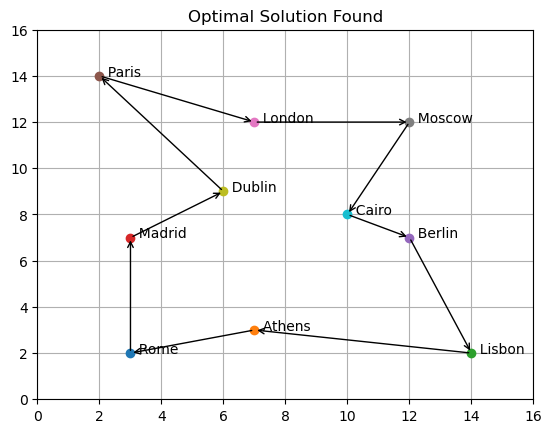

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

for city in city_list:
    ax.plot(city.x, city.y, 'o')
    ax.annotate(f'  {city.Name}', xy=(city.x, city.y))
# _end_for_

# Get the size of the genome.
N = len(optimal_solution.genome)

# Iterate through all the cities.
for i, city_a in enumerate(optimal_solution.genome):

    # The next index 'j' should point at the
    # begining of the list, once we reach the end.
    j = i + 1 if i < N-1 else 0

    # Get the next city in the list.
    city_b = optimal_solution.genome[j]

    x_a, y_a = city_a.datum.x, city_a.datum.y
    x_b, y_b = city_b.datum.x, city_b.datum.y

    ax.annotate("", xy=(x_a, y_a), xytext=(x_b, y_b),
                arrowprops=dict(arrowstyle="<-"))
# _end_for_

ax.grid()

ax.set_xlim([0, 16])
ax.set_ylim([0, 16])

plt.title("Optimal Solution Found")
plt.show()